# Entrenamiento de modelos con MetaData

### Imports

In [ ]:
import itertools

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

# Preprocesamiento
from sklearn.preprocessing import OneHotEncoder

# Métricas
from sklearn.metrics import roc_auc_score

# Modelo
## Definir cómo se combinan los modelos para la predicción.
from sklearn.ensemble import VotingClassifier
## Para trabajar con sampleos en clases desbalanceadas
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
## Modelo lightgbm
import lightgbm as lgb

# Cross-Validation para caso desbalanceado
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
# Explicabilidad
import shap


## Load Data & Feature engineering

### Ruta hacia los datos
-Cambiar si es necesario-

In [ ]:
print("Mounting your Google Drive ...")

from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive',force_remount=True)

path = "/content/drive/My Drive/data_ISIC"

Mounting your Google Drive ...
Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
train_path = path + '/train-metadata.csv'
train_path_split = path + '/train_split.csv'
validation_path_split = path + '/validation_split.csv'
#test_path = path + '/test-metadata.csv'
#subm_path = path + '/sample_submission.csv'
#filtereth_path = path + '/train_original.csv.xls'

In [ ]:
df_train = pd.read_csv(train_path)
df_train_split = pd.read_csv(train_path_split, index_col=0)
df_validation = pd.read_csv(validation_path_split, index_col=0)

<ipython-input-4-58c016231e36>:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(train_path)


In [ ]:
df_train_split = df_train_split['isic_id']

In [ ]:
df_validation = df_validation['isic_id']

In [ ]:
df_train.head(5)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [ ]:
df_train_split.head(5)

,isic_id
168765,ISIC_4257482
344564,ISIC_8604888
5582,ISIC_0209050
323980,ISIC_8099764
263886,ISIC_6615693


In [ ]:
df_validation.head(5)

,isic_id
168903,ISIC_4260773
388956,ISIC_9697201
332109,ISIC_8301065
148288,ISIC_3753800
25154,ISIC_0690097


In [ ]:
df_train_final = df_train.merge(df_train_split, on='isic_id', how='inner')

In [ ]:
df_train_final.head(5)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
4,ISIC_0035502,0,IP_3026693,75.0,female,head/neck,2.54,TBP tile: close-up,3D: white,22.129183,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.619603


In [ ]:
len(df_train_final) == len(df_train_split), len(df_train_final.columns) == len(df_train.columns)

(True, True)

In [ ]:
set(df_train_final.columns) - set(df_train.columns)

set()

### Columnas de los dataset y agregación de features

In [ ]:
id_col = 'isic_id'
target_col = 'target'
group_col = 'patient_id'

err = 1e-5

In [ ]:
num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]

new_num_cols = [
    'lesion_size_ratio',             # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',            # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                  # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',            # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',       # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt
    'border_complexity',             # tbp_lv_norm_border      + tbp_lv_symm_2axis
    'color_uniformity',              # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',          # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',       # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',       # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',       # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',   # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',   # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',             # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',             # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',          # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',     # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',         # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',        # border_complexity       + lesion_shape_index
    'color_contrast_index',          # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',               # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',        # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',           # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',              # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',   # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',         # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',      # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',# tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',    # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',          # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',      # tbp_lv_norm_border      * tbp_lv_norm_color
    'border_color_interaction_2',
    'size_color_contrast_ratio',     # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',# tbp_lv_nevi_confidence  / age_approx
    'age_normalized_nevi_confidence_2',
    'color_asymmetry_index',         # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',       # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                   # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',       # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',           # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',       # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',       # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
]

In [ ]:
cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']
norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
special_cols = ['count_per_patient'] + [f'{col}_count' for col in cat_cols] + [(f'{num_col}_{cat_col}') for num_col, cat_col in itertools.product(num_cols, cat_cols)]
feature_cols = num_cols + new_num_cols + cat_cols + norm_cols + special_cols

### Función para cargar los datos y añadir las features

In [ ]:
def read_data(path):
    return (
        pl.read_csv(path)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()), # You may want to impute test data with train
        )
        .with_columns(
            lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + err),
        )
        .with_columns(
            position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site       = pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        )
        .with_columns(
            ((pl.col(num_col) - pl.col(num_col).mean().over('patient_id', cat_col)) / (pl.col(num_col).std().over('patient_id', cat_col) + err)).alias(f'{num_col}_{cat_col}') for num_col, cat_col in itertools.product(num_cols, cat_cols)
        )
        .with_columns(
            pl.col(col).count().over('patient_id', col).alias(f'{col}_count') for col in cat_cols
        )
        .with_columns(
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index(id_col)
    )

## Preprocesamiento

In [ ]:
def preprocess(df_train, df_test):
    global cat_cols

    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])

    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols

    return df_train, df_test

## Métrica Custom

In [ ]:
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)

    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])

    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)

    return partial_auc

## Lectura y procesamiento de los datos

In [ ]:
df_train = read_data(train_path)
#df_test = read_data(test_path)
#df_subm = pd.read_csv(subm_path, index_col=id_col)

df_train, _ = preprocess(df_train, df_train)

## Filtrado con train_original

In [ ]:
# filter_df = pd.read_csv(filtereth_path)


# df_train = df_train[df_train.index.isin(filter_df['isic_id'])]

## Modelo

### Hyperparámetros para LGBM

In [ ]:
lgb_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'n_iter':           200,
    'n_jobs':           2,
    'boosting_type':    'gbdt',
    'lambda_l1':        0.03335206514282942,
    'lambda_l2':        0.005157393323802471,
    'learning_rate':    0.030665870185795318,
    'max_depth':        7,
    'num_leaves':       239,
    'colsample_bytree': 0.7573175155547233,
    'colsample_bynode': 0.5005423904042993,
    'bagging_fraction': 0.7937347683420382,
    'bagging_freq':     4,
    'min_data_in_leaf': 29,
    'scale_pos_weight': 1.648349898918236,
}
sampling_ratio = 0.01

### Definición del modelo

In [ ]:
estimator = VotingClassifier([
    ('lgb1', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=12)),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=12)),
    ])),
    ('lgb2', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=22)),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=22)),
    ])),
    ('lgb3', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=32)),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=32)),
    ])),
    ('lgb4', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=42)),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=42)),
    ])),
    ('lgb5', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=52)),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=52)),
    ])),
], voting='soft')


## Cross-Validation

In [ ]:
seed = 42

In [ ]:
X = df_train[feature_cols]
y = df_train[target_col]
groups = df_train[group_col]
cv = StratifiedGroupKFold(5, shuffle=True, random_state=seed)

val_score = cross_val_score(
    estimator=estimator,
    X=X, y=y,
    cv=cv,
    groups=groups,
    scoring=custom_metric,
)

np.mean(val_score), val_score

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warnin

(np.float64(0.17685230701462043),
 array([0.17209049, 0.17410626, 0.18599515, 0.17563064, 0.17643901]))

## Training

In [ ]:
X, y = df_train[feature_cols], df_train[target_col]

estimator.fit(X, y)

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warnin

VotingClassifier(estimators=[('lgb1',
                              Pipeline(steps=[('sampler',
                                               RandomUnderSampler(random_state=12,
                                                                  sampling_strategy=0.01)),
                                              ('classifier',
                                               LGBMClassifier(bagging_fraction=0.7937347683420382,
                                                              bagging_freq=4,
                                                              colsample_bynode=0.5005423904042993,
                                                              colsample_bytree=0.7573175155547233,
                                                              lambda_l1=0.03335206514282942,
                                                              lambda_l2=0.005157393323802471,
                                                              learning_rate...
                                                              bagging_freq=4,
                                                              colsample_bynode=0.5005423904042993,
                                                              colsample_bytree=0.7573175155547233,
                                                              lambda_l1=0.03335206514282942,
                                                              lambda_l2=0.005157393323802471,
                                                              learning_rate=0.030665870185795318,
                                                              max_depth=7,
                                                              min_data_in_leaf=29,
                                                              n_iter=200,
                                                              n_jobs=2,
                                                              num_leaves=239,
                                                              objective='binary',
                                                              random_state=52,
                                                              scale_pos_weight=1.648349898918236,
                                                              verbosity=-1))]))],
                 voting='soft')

In [ ]:
# model = estimator.named_estimators_['lgb1']
# lgbm_model = model.named_steps['classifier']

# X_shap = X.copy()

# explainer = shap.Explainer(lgbm_model)

# shap_values = explainer(X_shap)

# shap.summary_plot(shap_values, X_shap, feature_names=feature_cols)


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


SHAP Summary para Ensemble (Promedio)


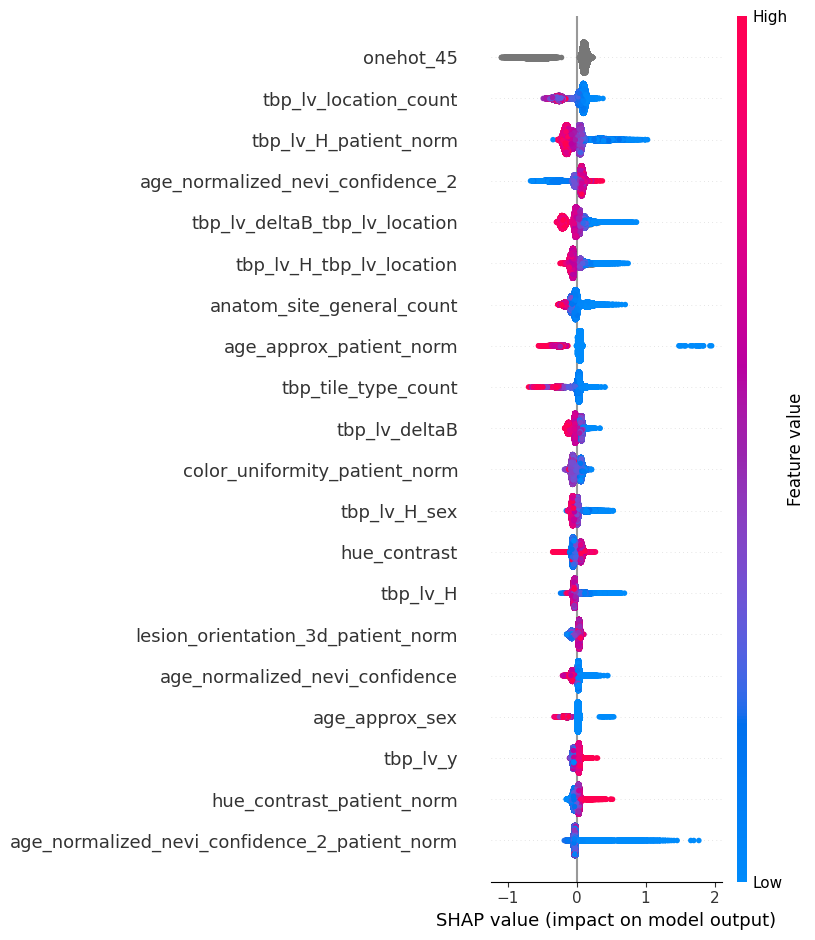

In [ ]:
# # for name in estimator.named_estimators_:
# #     model = estimator.named_estimators_[name]
# #     lgbm_model = model.named_steps['classifier']

# #     explainer = shap.Explainer(lgbm_model)
# #     shap_values = explainer(X)

# #     print(f"SHAP Summary for {name}")
# #     shap.summary_plot(shap_values, X, feature_names=feature_cols)


# # Asumimos peso uniforme por modelo
# weights = {name: 1/len(estimator.named_estimators_) for name in estimator.named_estimators_}

# # Diccionario para guardar shap_values
# shap_values_weighted_sum = None

# for name in estimator.named_estimators_:
#     model = estimator.named_estimators_[name]
#     lgbm_model = model.named_steps['classifier']

#     explainer = shap.Explainer(lgbm_model)
#     shap_values = explainer(X)

#     print(f"SHAP Summary for {name}")
#     shap.summary_plot(shap_values, X, feature_names=feature_cols)

#     # Ponderación de los shap values
#     weighted_values = shap_values.values * weights[name]

#     # Acumulación de SHAP values ponderados
#     if shap_values_weighted_sum is None:
#         shap_values_weighted_sum = weighted_values
#     else:
#         shap_values_weighted_sum += weighted_values

# # Mostrar SHAP summary del ensemble (promedio ponderado)
# print("SHAP Summary for Ensemble (Weighted Average)")
# shap.summary_plot(shap_values_weighted_sum, X, feature_names=feature_cols)


# Asumimos peso uniforme por modelo

from sklearn.model_selection import train_test_split

# Split Train/Validation para SHAP y BorutaShap (20% validación)
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

# SHAP con promedio de 5 modelos
lgbm_pipelines = [pipe for name, pipe in estimator.named_estimators_.items()]
shap_values_list = []
base_values_list = []

for pipeline in lgbm_pipelines:
    model = pipeline.named_steps['classifier']
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_val_meta)
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[1]
    shap_values_list.append(shap_vals)
    base_values_list.append(explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value)

# Promedio de SHAP y expected_value
shap_values_avg = np.mean(shap_values_list, axis=0)
base_value_avg = np.mean(base_values_list)

# Crear objeto Explanation final
ensemble_shap = shap.Explanation(
    values=shap_values_avg,
    base_values=np.full(shap_values_avg.shape[0], base_value_avg),
    data=X_val_meta.values,
    feature_names=feature_cols
)

# Mostrar SHAP Summary
print("SHAP Summary para Ensemble (Promedio)")
shap.summary_plot(ensemble_shap, X_val_meta, feature_names=feature_cols)

In [ ]:
top_n = 10

# Usamos el SHAP promedio ya calculado sobre X_val_meta
mean_abs_shap = np.abs(shap_values_avg).mean(axis=0)

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'mean_abs_shap': mean_abs_shap
}).sort_values(by='mean_abs_shap', ascending=False)

print(f"\nTop {top_n} Features más importantes (SHAP promedio):\n")
print(importance_df.head(top_n))


Top 10 Features más importantes (SHAP promedio):

                              feature  mean_abs_shap
408                         onehot_45       0.191328
156             tbp_lv_location_count       0.134191
84              tbp_lv_H_patient_norm       0.129587
68   age_normalized_nevi_confidence_2       0.101948
258     tbp_lv_deltaB_tbp_lv_location       0.100382
210          tbp_lv_H_tbp_lv_location       0.082035
154         anatom_site_general_count       0.076836
76            age_approx_patient_norm       0.074532
155               tbp_tile_type_count       0.072712
16                      tbp_lv_deltaB       0.065663


<Figure size 1000x600 with 0 Axes>

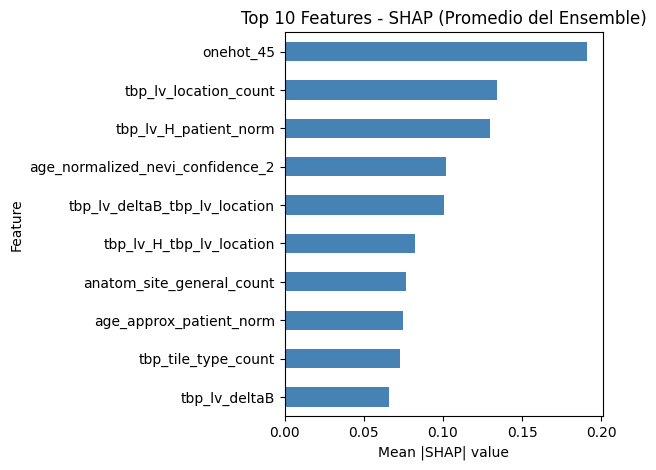

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
importance_df.head(top_n).sort_values('mean_abs_shap').plot(
    kind='barh',
    x='feature',
    y='mean_abs_shap',
    legend=False,
    color='steelblue'
)
plt.xlabel('Mean |SHAP| value')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Features - SHAP (Promedio del Ensemble)')
plt.tight_layout()
plt.show()

In [37]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

# Función personalizada para calcular Partial ROC AUC escalado
def calculate_custom_partial_auc(y_true, y_pred_proba_positive_class):
    min_tpr_threshold = 0.80
    max_fpr_threshold = abs(1 - min_tpr_threshold)

    v_gt = np.abs(y_true - 1)
    v_pred_proba_negative_class = 1.0 - y_pred_proba_positive_class

    partial_auc_scaled = roc_auc_score(v_gt, v_pred_proba_negative_class, max_fpr=max_fpr_threshold)
    custom_scaled_auc = partial_auc_scaled
    true_partial_auc = custom_scaled_auc * (max_fpr_threshold - 0.5 * max_fpr_threshold**2) + 0.5 * max_fpr_threshold**2

    return true_partial_auc

# Predicciones (probabilidades y clases) para train y validación
y_train_probs = estimator.predict_proba(X_train_meta)[:, 1]
y_val_probs = estimator.predict_proba(X_val_meta)[:, 1]

y_train_pred = estimator.predict(X_train_meta)
y_val_pred = estimator.predict(X_val_meta)

# --- TRAIN ---
partial_roc_auc_train = calculate_custom_partial_auc(y_train_meta, y_train_probs)
bal_acc_train = balanced_accuracy_score(y_train_meta, y_train_pred)

# --- VALIDATION ---
partial_roc_auc_val = calculate_custom_partial_auc(y_val_meta, y_val_probs)
bal_acc_val = balanced_accuracy_score(y_val_meta, y_val_pred)
roc_auc_val = roc_auc_score(y_val_meta, y_val_probs)

# Resultados
print("MÉTRICAS EN TRAIN")
print(f"Partial ROC AUC (max_fpr=0.2): {partial_roc_auc_train}")
print(f"Balanced Accuracy: {bal_acc_train}")
print(f"ROC AUC: {roc_auc_train}")

print("\nMÉTRICAS EN VALIDACIÓN")
print(f"Partial ROC AUC (max_fpr=0.2): {partial_roc_auc_val}")
print(f"Balanced Accuracy: {bal_acc_val}")
print(f"ROC AUC: {roc_auc_val}")

MÉTRICAS EN TRAIN
Partial ROC AUC (max_fpr=0.2): 0.19997883004623607
Balanced Accuracy: 0.9996271834725285
ROC AUC: 0.9999338879840686

MÉTRICAS EN VALIDACIÓN
Partial ROC AUC (max_fpr=0.2): 0.19998396652906314
Balanced Accuracy: 0.9996505809092384
ROC AUC: 0.999958613109503


In [ ]:
from BorutaShap import BorutaShap

# Para almacenar los resultados de cada modelo
boruta_results = {}

# Aplicamos BorutaShap a cada modelo individual del ensemble
for name in estimator.named_estimators_:
    print(f"Ejecutando BorutaShap para {name}...")

    model = estimator.named_estimators_[name]
    lgbm_model = model.named_steps['classifier']

    boruta_selector = BorutaShap(
        model=lgbm_model,
        importance_measure='shap',
        classification=True,
    )

    # BorutaShap con train-val split hecho previamente
    boruta_selector.fit(
        X=X_val_meta,
        y=y_val_meta,
        n_trials=100,
        sample=False,
        normalize=True
    )

    boruta_results[name] = boruta_selector
    boruta_selector.plot()

In [ ]:
importances_list = []

for name, boruta in boruta_results.items():
    # Obtengo las importancias y el segundo vector que devuelve la función
    mean_shap, other_values = boruta.feature_importance(normalize=True)

    features = boruta.columns

    #DataFrame con las importancias y las features
    imp_df = pd.DataFrame({
        'feature': features,
        'mean_boruta': mean_shap,
        'other_metric': other_values
    })

    # Agrego una columna para el modelo (para identificar luego)
    imp_df['model'] = name

    importances_list.append(imp_df)

all_importances_df = pd.concat(importances_list, axis=0)


print(all_importances_df.head())

mean_importances = all_importances_df.groupby('feature')['mean_boruta'].mean().sort_values(ascending=False)
print(mean_importances)



In [ ]:
import matplotlib.pyplot as plt

mean_importances.head(15).plot(kind='barh', figsize=(8,6))
plt.gca().invert_yaxis()
plt.xlabel('Importancia media SHAP')
plt.title('Top 20 features promedio (SHAP) - BorutaShap')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Boxplot: cada feature vs distribución de importancias
sns.boxplot(x='mean_boruta', y='feature', data=all_importances_df, orient='h')

plt.title('Distribución de importancias SHAP por feature (BorutaShap)')
plt.xlabel('Importancia media SHAP')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
